In [8]:
import json
import numpy as np
from neuralNetwork import NeuralNetwork, In_between_epochs
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer, AutoTokenizer, AutoModel
from helper import dict_lists_to_list_of_dicts, get_train_valdiation_test_split, Dataset
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
from transformers import logging
logging.set_verbosity_error()

### Importing the dataset:

In [9]:
f = open("ECHR_Corpus.json",encoding= 'utf-8')
dataset = json.load(f)
f.close()

In [10]:
refactored_dataset = []
for datapoint in dataset:
    text = datapoint["text"]
    dict_clauses = {}
    for clause in datapoint["clauses"]:
        start = clause["start"]
        end = clause["end"]
        id = clause["_id"]
        dict_clauses[id] = text[start:end]
    refactored_dataset.append({
        "text": text,
        "arguments": datapoint["arguments"],
        "n_clauses": len(datapoint["clauses"]),
        "all_clauses": dict_clauses
    })

In [11]:
n_arguments = []
n_premises = []
n_clauses = []
for case in refactored_dataset:
    n_arguments.append(len(case["arguments"]))
    n_clauses.append(case["n_clauses"])
    for argument in case["arguments"]:
        n_premises.append(len(argument["premises"]))
print(f"""
On average, a case has {np.mean(n_clauses):.2f} clauses with a median of {np.median(n_clauses):.0f} clauses per case.
On average, a case has {np.mean(n_arguments):.2f} arguments with a median of {np.median(n_arguments):.0f} arguments per case.
Each argument, on average, has: {np.mean(n_premises):.2f} premises with a median of {np.median(n_premises):.0f} premises per argument.
""")


On average, a case has 248.95 clauses with a median of 226 clauses per case.
On average, a case has 17.69 arguments with a median of 14 arguments per case.
Each argument, on average, has: 2.63 premises with a median of 2 premises per argument.



In [12]:
premise = "\n\t".join([refactored_dataset[0]["all_clauses"][premise] for premise in refactored_dataset[0]["arguments"][0]["premises"]])
conclusion = refactored_dataset[0]["all_clauses"][refactored_dataset[0]["arguments"][0]["conclusion"]]
print(f"""
Here an example of an argument:
    - Premises:
        {premise}
    - Conclusion:
        {conclusion}
""")


Here an example of an argument:
    - Premises:
        The Commission notes that the applicant was detained after having been sentenced by the first instance court to 18 months' imprisonment.
	He was released after the Court of Appeal reviewed this sentence, reducing it to 15 months' imprisonment, convertible to a fine.
    - Conclusion:
        The Commission finds that the applicant was deprived of his liberty "after conviction by a competent court" within the meaning of Article 5 para. 1 (a) (Art. 5-1-a) of the Convention.



## Prepare for training
We will declare some general stuff that will be used with all the different tasks

In [13]:
# The two bert models we will focus on
LEGAL_BERT = "nlpaueb/legal-bert-base-uncased"
ROBERTA = "FacebookAI/roberta-base"

In [14]:
# A test tokenizer
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")

In [15]:
#torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("operating on device:", device)

operating on device: cuda:0


In [16]:
#Early stopping which allows us to train avoiding overfitting 
class EarlyStopping(In_between_epochs):
    def __init__(self, delta, patience, hyper_param, model_class):
        self.delta = delta
        self.patience = patience
        self.current_patience = 0
        self.best_valid_loss = np.inf
        self.best_model = model_class(**hyper_param)
        self.epochs = 0
    
    def __call__(self, model:torch.nn.Module, loaders:dict[str,torch.utils.data.DataLoader], device:'torch.device|str', output_extraction_function, losses:dict[str, float]) -> bool:
        self.epochs += 1
        if losses["validation"] < self.best_valid_loss - self.delta:
            self.best_valid_loss = losses["validation"]
            self.best_model.load_state_dict(model.state_dict())
            self.current_patience = 0
        else:
            self.current_patience += 1
            if self.current_patience >= self.patience:
                return True
        return False
    def reset(self):
        self.current_patience = 0
        self.epochs = 0

In [17]:
# A train function that adapts the learning rate during training
def train(model, train, validation, min_lr, start_lr, early_stopping, frac, loss):
    tot_train_data, tot_val_data = [], []
    lr = start_lr
    while lr > min_lr:
        print(f'learning rate = {lr:.4f}', end="\r")
        train_data, validation_data = model.train_network(train, 
                        validation, 
                        torch.optim.Adam, 
                        loss_function=loss,
                        device=device, 
                        batch_size=32,
                        verbose=True, 
                        output_extraction_function= lambda x: torch.max(x, -1)[1].view(-1).cpu(), 
                        metrics={
                        "accuracy": accuracy_score, 
                        "f1_score": lambda y_true, y_pred: f1_score(y_true, y_pred, average="macro")},
                        in_between_epochs = {"early_stopping": early_stopping},
                        learning_rate=lr,
                        epochs=30)
        train_data["epochs"] = early_stopping.epochs
        train_data["lr"] = lr
        validation_data["epochs"] = early_stopping.epochs
        validation_data["lr"] = lr
        tot_train_data.append(train_data)
        tot_val_data.append(validation_data)
        model.load_state_dict(early_stopping.best_model.state_dict())
        lr = lr * frac
        early_stopping.reset()
    early_stopping.best_model = early_stopping.best_model.to("cpu")
    return tot_train_data, tot_val_data

In [18]:
# A meta-training function that allows us to train all the folds
def fold_training(cases, bert_type, min_lr, start_lr, lr_multiplier, get_dataloader, model_class, loss=nn.CrossEntropyLoss()):
    best_models = []
    if bert_type == ROBERTA:
        tokenizer = RobertaTokenizer.from_pretrained(bert_type)
    else:
        tokenizer = AutoTokenizer.from_pretrained(bert_type)
    for cases_split in cases:
        train_cases, validation_cases, _ = cases_split
        train_dataloader = get_dataloader(train_cases, tokenizer, shuffle=True, batch_size=8, verbose=False)
        validation_dataloder = get_dataloader(validation_cases, tokenizer, batch_size=8, verbose=False)
        model = model_class(2, bert_type)
        early_stopping = EarlyStopping(.001, 3, {"out_features": 2, "bert_type": bert_type}, model_class)
        train_data_fold, val_data_fold = train(model, train_dataloader, validation_dataloder, min_lr, start_lr, early_stopping, lr_multiplier, loss)
        model.load_state_dict(early_stopping.best_model.state_dict())
        model = model.to("cpu")
        best_models.append({"loss": early_stopping.best_valid_loss, "model": model, "data":{"train": train_data_fold, "val":val_data_fold }})
        del early_stopping.best_model
        del early_stopping
        torch.cuda.empty_cache()
    
    return best_models

In [19]:
# The cases splits we will use to train
cases = get_train_valdiation_test_split(refactored_dataset, [4])

In [20]:
for i in range(len(cases)):
    train_cases, validation_cases, test_cases = cases[i]
    print(f"""there are {len(train_cases)} cases in the training set (fold {i}), 
    {len(validation_cases)} cases in the validation set (fold {i}) and
    {len(test_cases)} cases in the test set (fold {i})
    """)

there are 28 cases in the training set (fold 0), 
    6 cases in the validation set (fold 0) and
    8 cases in the test set (fold 0)
    
there are 28 cases in the training set (fold 1), 
    6 cases in the validation set (fold 1) and
    8 cases in the test set (fold 1)
    
there are 28 cases in the training set (fold 2), 
    6 cases in the validation set (fold 2) and
    8 cases in the test set (fold 2)
    
there are 28 cases in the training set (fold 3), 
    6 cases in the validation set (fold 3) and
    8 cases in the test set (fold 3)
    
there are 28 cases in the training set (fold 4), 
    6 cases in the validation set (fold 4) and
    8 cases in the test set (fold 4)
    


# Task 1: Argument Clause Recognition

We begin by defining the dataloader:

In [21]:
def get_acr_dataloader(cases, tokenizer, batch_size=16, shuffle=False, verbose=True):
    ACR_x = []
    ACR_y = []
    for case in cases:
        n_clauses = case["n_clauses"]
        clauses = case["all_clauses"]
        args_set = set()
        splitter = "AS TO THE LAW" if "AS TO THE LAW" in case["text"] else "THE LAW" #We use as training data only text coming from the "as to the law" sections
        law_section = case["text"].split(splitter)[1]
        for argument in case["arguments"]:
            if not argument["conclusion"] in args_set and clauses[argument["conclusion"]] in law_section:
                ACR_x.append(clauses[argument["conclusion"]])
                ACR_y.append(torch.tensor([1.,0.]))
                args_set.add(argument["conclusion"])
            for premise in argument["premises"]:
                if not premise in args_set and clauses[premise] in law_section:
                    ACR_x.append(clauses[premise])
                    ACR_y.append(torch.tensor([1.,0.]))
                    args_set.add(premise)
        for clause_id in clauses.keys():
            if not clause_id in args_set and clauses[clause_id] in law_section:
                ACR_x.append(clauses[clause_id])
                ACR_y.append(torch.tensor([0.,1.]))
    if verbose:
        print(f"""
    There are:
        - {len(ACR_x)} clause
        - {len([a for a in ACR_y if a[0] == 1])} argument clause
        - {len([a for a in ACR_y if a[0] == 0])} non-argument clause
    """)
    
    ACR_x_tokenized = dict_lists_to_list_of_dicts(tokenizer(ACR_x, padding=True, truncation=True, return_tensors='pt'))
    dataset = Dataset(ACR_x_tokenized, ACR_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
train_cases, validation_cases, test_cases = cases[-1]
print('Fold 4:')
print("train set:")
train_dataloader = get_acr_dataloader(train_cases, tokenizer, shuffle=True, batch_size=8)
print("validation set:")
validation_dataloder = get_acr_dataloader(validation_cases, tokenizer, batch_size=8)
print("test set:")
test_dataloader = get_acr_dataloader(test_cases, tokenizer, batch_size=8)

Fold 4:
train set:

    There are:
        - 3355 clause
        - 1846 argument clause
        - 1509 non-argument clause
    
validation set:

    There are:
        - 288 clause
        - 223 argument clause
        - 65 non-argument clause
    
test set:

    There are:
        - 1046 clause
        - 624 argument clause
        - 422 non-argument clause
    


## Train

The architecture is the same for both Legal bert and Roberta models:

In [22]:
class Model(NeuralNetwork):
    def __init__(self, out_features:int, bert_type:str, dropout:float = 0.2) -> None:
        super().__init__()
        if bert_type == "FacebookAI/roberta-base":
            self.encoder = RobertaModel.from_pretrained(bert_type)
        else:
            self.encoder = AutoModel.from_pretrained(bert_type)
        self.output_layer = nn.Linear(self.encoder.config.hidden_size, out_features)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        encoded_input, _ = self.encoder(**input, return_dict = False)
        encoded_input = self.dropout(encoded_input)
        encoded_input = torch.nn.functional.avg_pool1d(
            encoded_input.permute(0, 2, 1), 
            kernel_size=encoded_input.size(1)
        ).squeeze(2)
        if len(encoded_input.size()) != 2:
            print(encoded_input.size())
        return self.output_layer(encoded_input).float()

    def freeze_bert(self):
        for param in self.encoder.parameters():
                param.requires_grad = False
    def unfreeze_bert(self):
        for param in self.encoder.parameters():
                param.requires_grad = True
    

In [23]:
legal_bert_models = fold_training(cases, LEGAL_BERT, 5e-7, 1e-6, .6, get_acr_dataloader, Model)

EPOCH 1 training loss:      0.587 - validation loss:      0.650                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.709 - validation accuracy:      0.655
EPOCH 1 training f1_score:      0.644 - validation f1_score:      0.481
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.497 - validation loss:      0.673                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.767 - validation accuracy:      0.660
EPOCH 2 training f1_score:      0.722 - validation f1_score:  

In [24]:
for i, model_data in enumerate(legal_bert_models):
    f = open(f"legal_bert_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(legal_bert_models):
    torch.save(model_info["model"].state_dict(), f"best_model_legal_bert_fold_{i}")

In [25]:
roberta_models = fold_training(cases, ROBERTA, 5e-7, 1e-6, .6, get_acr_dataloader, Model)

EPOCH 1 training loss:      0.581 - validation loss:      0.644                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.688 - validation accuracy:      0.613
EPOCH 1 training f1_score:      0.649 - validation f1_score:      0.448
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.491 - validation loss:      0.729                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.752 - validation accuracy:      0.633
EPOCH 2 training f1_score:      0.720 - validation f1_score:  

In [27]:
for i, model_data in enumerate(roberta_models):
    f = open(f"trainings/6.1/roberta_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(roberta_models):
    torch.save(model_info["model"].state_dict(), f"weights/6.1/best_model_roberta_fold_{i}")

In [29]:
legal_bert_models = []
for fold in range(5):
    f = open(f"trainings/6.1/legal_bert_fold_{fold}.json")
    data = json.load(f)
    model = Model(2, LEGAL_BERT)
    model.load_state_dict(torch.load(f"weights/6.1/best_model_legal_bert_fold_{fold}"))
    losses = [train["loss"] for train in data["val"]]
    loss = []
    for l in losses:
        loss += l
    loss = min(loss)
    legal_bert_models.append({"loss": loss, "data":data, "model": model})

In [30]:
roberta_models = []
for fold in range(5):
    f = open(f"trainings/6.1/roberta_fold_{fold}.json")
    data = json.load(f)
    model = Model(2, ROBERTA)
    model.load_state_dict(torch.load(f"weights/6.1/best_model_roberta_fold_{fold}"))
    losses = [train["loss"] for train in data["val"]]
    loss = []
    for l in losses:
        loss += l
    loss = min(loss)
    roberta_models.append({"loss": loss, "data":data, "model": model})

In [31]:
best_model_fold = min(legal_bert_models, key= lambda x: x["loss"]) 
print(f"best legal bert model loss: {best_model_fold['loss']:.3f}")

best legal bert model loss: 0.426


In [32]:
best_model_fold = min(roberta_models, key= lambda x: x["loss"]) 
print(f"best roberta model loss: {best_model_fold['loss']:.3f}")

best roberta model loss: 0.491


## Training curves

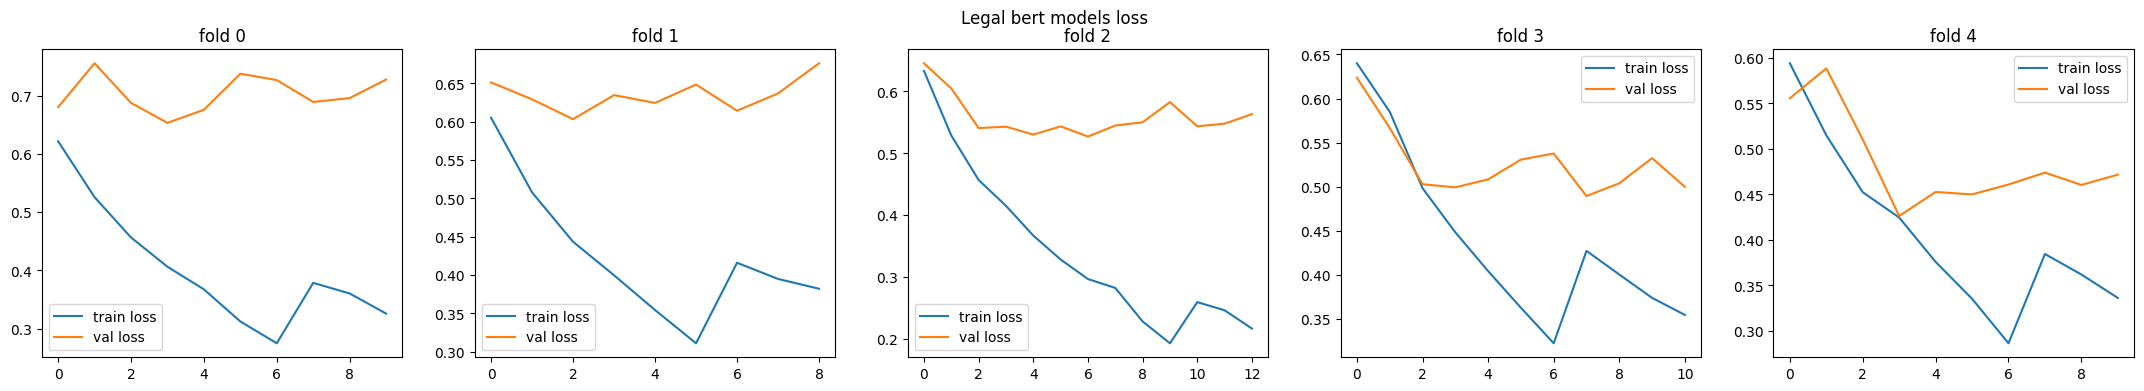

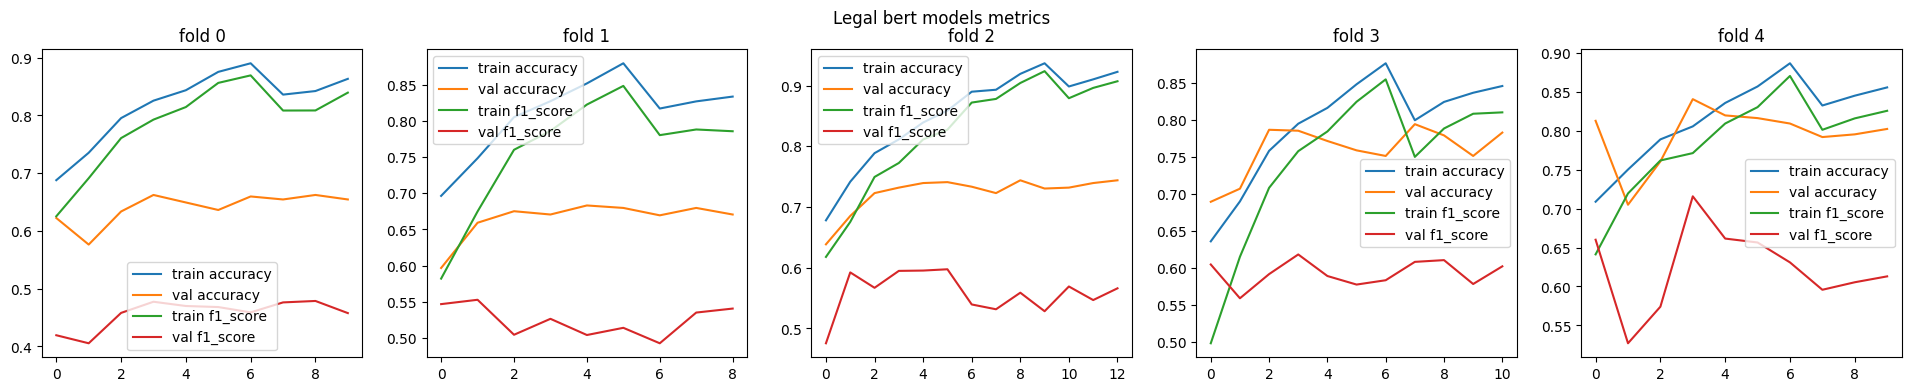

In [35]:
fig, axs = plt.subplots(ncols = len(legal_bert_models), figsize=(27, 4)) 
for fold, train_data in enumerate(legal_bert_models):
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = []
    for l in temp_list:
        train_metric += l
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = []
    for l in temp_list:
        val_metric += l
    x = [i for i in range(len(val_metric))]
    axs[fold].plot(x, train_metric, label="train loss")
    axs[fold].plot(x, val_metric, label="val loss")
    axs[fold].set_title(f"fold {fold}")
    axs[fold].legend()
fig.suptitle("Legal bert models loss")
plt.show()
fig, axs = plt.subplots(ncols = len(legal_bert_models), figsize=(24, 4)) 
for fold, train_data in enumerate(legal_bert_models):
    for metric in ["accuracy", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = []
        for l in temp_list:
            train_metric += l
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = []
        for l in temp_list:
            val_metric += l
        x = [i for i in range(len(val_metric))]
        axs[fold].plot(x, train_metric, label=f"train {metric}")
        axs[fold].plot(x, val_metric, label=f"val {metric}")
        axs[fold].set_title(f"fold {fold}")
        axs[fold].legend()
fig.suptitle("Legal bert models metrics")
plt.show()

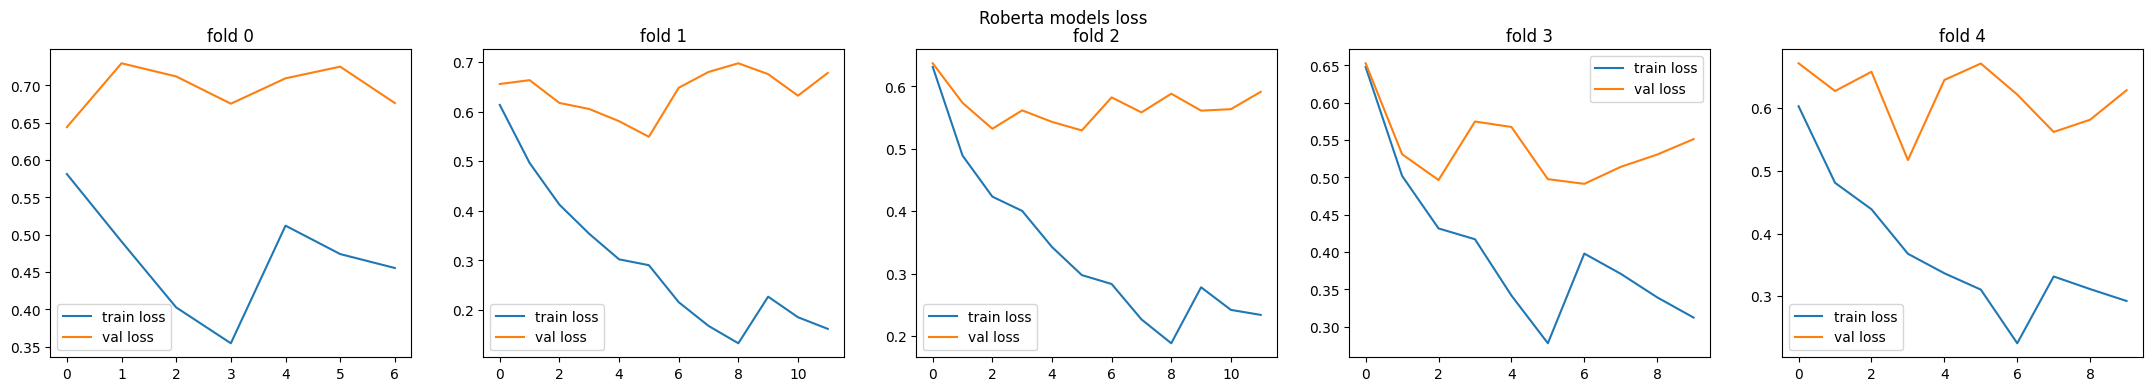

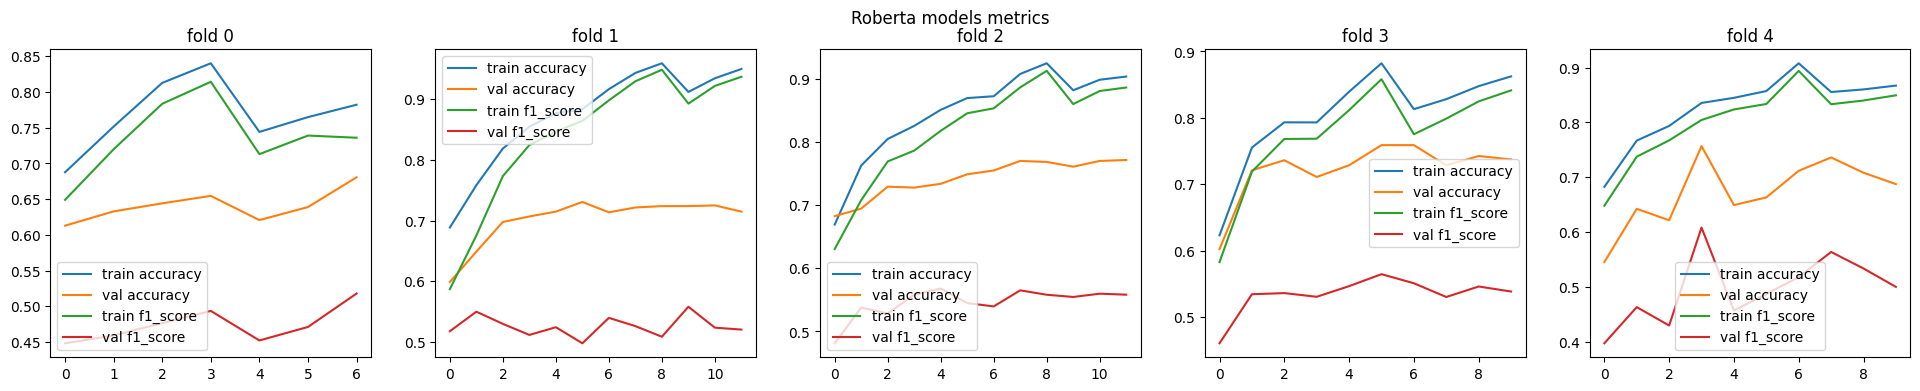

In [36]:
fig, axs = plt.subplots(ncols = len(roberta_models), figsize=(27, 4)) 
for fold, train_data in enumerate(roberta_models):
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = []
    for l in temp_list:
        train_metric += l
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = []
    for l in temp_list:
        val_metric += l
    x = [i for i in range(len(val_metric))]
    axs[fold].plot(x, train_metric, label="train loss")
    axs[fold].plot(x, val_metric, label="val loss")
    axs[fold].set_title(f"fold {fold}")
    axs[fold].legend()
fig.suptitle("Roberta models loss")
plt.show()
fig, axs = plt.subplots(ncols = len(roberta_models), figsize=(24, 4)) 
for fold, train_data in enumerate(roberta_models):
    for metric in ["accuracy", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = []
        for l in temp_list:
            train_metric += l
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = []
        for l in temp_list:
            val_metric += l
        x = [i for i in range(len(val_metric))]
        axs[fold].plot(x, train_metric, label=f"train {metric}")
        axs[fold].plot(x, val_metric, label=f"val {metric}")
        axs[fold].set_title(f"fold {fold}")
        axs[fold].legend()
fig.suptitle("Roberta models metrics")
plt.show()

In [37]:
best_model = Model(2, LEGAL_BERT)
best_model_fold = min(legal_bert_models, key= lambda x: x["loss"]) 
best_model.load_state_dict(best_model_fold["model"].state_dict())
best_model = best_model.to(device)
best_model.eval()

Model(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [38]:
#Ricontrollare e aggiungere roberta (ricordare di cambiare tokenizer)
#also: mettiamo in coda?

def full_test(model, cases, tokenizer, device):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for case in cases:
            clauses = case["all_clauses"]
            args_set = set()
            splitter = "AS TO THE LAW" if "AS TO THE LAW" in case["text"] else "THE LAW"
            law_section = case["text"].split(splitter)[1]
            for argument in case["arguments"]:
                if (argument["conclusion"] not in args_set) and (clauses[argument["conclusion"]] in law_section):
                    tokenized_x = tokenizer(clauses[argument["conclusion"]],padding = True, truncation=True, return_tensors='pt')
                    tokenized_x = {key: tokenized_x[key].to(device) for key in tokenized_x.keys()}
                    pred = model(tokenized_x)
                    y_pred.append(torch.max(pred, -1)[1].view(-1).cpu().tolist()[0])
                    y_true.append(0)
                    keys = list(tokenized_x.keys())
                    for k in keys:
                        del tokenized_x[k]
                    del tokenized_x
                    args_set.add(argument["conclusion"])
                elif argument["conclusion"] not in args_set and clauses[argument["conclusion"]] not in law_section:
                    args_set.add(argument["conclusion"])
                    y_pred.append(1)
                    y_true.append(0)
                for premise in argument["premises"]:
                    if premise not in args_set and clauses[premise] in law_section:
                        tokenized_x = tokenizer(clauses[premise], padding = True, truncation=True, return_tensors='pt')
                        tokenized_x = {key: tokenized_x[key].to(device) for key in tokenized_x.keys()}
                        pred = model(tokenized_x)
                        y_pred.append(torch.max(pred, -1)[1].view(-1).cpu().tolist()[0])
                        y_true.append(0)
                        keys = list(tokenized_x.keys())
                        for k in keys:
                            del tokenized_x[k]
                        del tokenized_x
                        args_set.add(premise)
                        
                    elif premise not in args_set and clauses[premise] not in law_section:
                        args_set.add(premise)
                        y_pred.append(1)
                        y_true.append(0)
            for clause_id in clauses.keys():
                if (not clause_id in args_set) and (clauses[clause_id] in law_section):
                    tokenized_x = tokenizer(clauses[clause_id], padding = True, truncation=True, return_tensors='pt')
                    tokenized_x = {key: tokenized_x[key].to(device) for key in tokenized_x.keys()}
                    pred = model(tokenized_x)
                    y_pred.append(torch.max(pred, -1)[1].view(-1).cpu().tolist()[0])
                    y_true.append(1)
                    keys = list(tokenized_x.keys())
                    for k in keys:
                        del tokenized_x[k]
                    del tokenized_x
                    args_set.add(clause_id)
                    
                if (not clause_id in args_set) and (clauses[clause_id] not in law_section):
                    y_pred.append(1)
                    y_true.append(1)
    print(f"""accuracy: {accuracy_score(y_true, y_pred):.2f}
    f1: {f1_score(y_true, y_pred):.2f}
    precision: {precision_score(y_true, y_pred):.2f}
    recall: {recall_score(y_true, y_pred):.2f}""")
full_test(best_model, test_cases, AutoTokenizer.from_pretrained(LEGAL_BERT), device)

accuracy: 0.86
    f1: 0.89
    precision: 0.96
    recall: 0.83


# Task 2: Argument Relation Mining

ARM Dataloader:

In [16]:
def get_arm_dataloader(cases, tokenizer, batch_size=16, shuffle=False, verbose=True):
    args_set = set()    #Prepare ids of clauses that are parts of arguments
    for case in refactored_dataset: 
        for argument in case["arguments"]: 
            args_set.add(argument["conclusion"])
            for premise in argument["premises"]:
                args_set.add(premise)

    ARM_x = []
    ARM_y = []
    for case in cases:
        clause_pos={}
        for clause in case['all_clauses']:
            clause_pos[clause] = case['text'].find(case['all_clauses'][clause])
        sorted_clauses = sorted(clause_pos.items(), key=lambda kv: kv[1])

        for el1 in range(len(sorted_clauses)-1):
            if sorted_clauses[el1][0] in args_set:
                for el2 in sorted_clauses[el1+1:el1+6]:
                    if el2[0] in args_set:
                        ARM_x.append({'e1': case['all_clauses'][sorted_clauses[el1][0]], 'e2': case['all_clauses'][el2[0]]})
                        y = torch.tensor([0., 1.])
                        for arg in case['arguments']:
                            if sorted_clauses[el1][0] in arg['premises'] or sorted_clauses[el1][0] == arg['conclusion']:
                                if el2[0] in arg['premises'] or el2[0] == arg['conclusion']:
                                    y = torch.tensor([1., 0.])
                        ARM_y.append(y)
    firsts = [el["e1"] for el in ARM_x]
    seconds = [el["e2"] for el in ARM_x]
    firsts = tokenizer.batch_encode_plus(
    firsts,
    add_special_tokens=True,
    padding = True,
    truncation=True,
    return_tensors='pt'
    )
    seconds = tokenizer.batch_encode_plus(
    seconds,
    add_special_tokens=True,
    padding = True,
    truncation=True,
    return_tensors='pt'
    )
    firsts = dict_lists_to_list_of_dicts(firsts)
    seconds = dict_lists_to_list_of_dicts(seconds)
    ARM_x_tokenized = [{"e1": firsts[i], "e2": seconds[i]} for i in range(len(firsts))]
    dataset = Dataset(ARM_x_tokenized, ARM_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

ARM_train_dataloader = get_arm_dataloader(train_cases, tokenizer, shuffle=True, batch_size=8)
ARM_validation_dataloder = get_arm_dataloader(validation_cases, tokenizer, batch_size=8)
ARM_test_dataloader = get_arm_dataloader(test_cases, tokenizer, batch_size=8)

## Train

Model1 feeds the two clauses to the encoder separately and then applies the linear layer to both outputs.

Molel2 applies the classification layer to the encoding of the concatenation of both clauses. 

In [17]:
class Model1(NeuralNetwork):
    def __init__(self, out_features:int, bert_type:str, dropout:float = .2) -> None:
        super().__init__()
        self.encoder = AutoModel.from_pretrained(bert_type)
        self.output_layer = nn.Linear(self.encoder.config.hidden_size * 2, out_features)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        encoded_input_1, _ = self.encoder(**input["e1"], return_dict = False)
        encoded_input_2, _ = self.encoder(**input["e2"], return_dict = False)
        
        encoded_input_1 = torch.nn.functional.avg_pool1d(
            encoded_input_1.permute(0, 2, 1), 
            kernel_size=encoded_input_1.size(1)
        ).squeeze(2)
        encoded_input_2 = torch.nn.functional.avg_pool1d(
            encoded_input_2.permute(0, 2, 1), 
            kernel_size=encoded_input_2.size(1)
        ).squeeze(2)
        encoded_input = self.dropout(torch.cat((encoded_input_1, encoded_input_2), dim=1))
        if len(encoded_input.size()) != 2:
            print(encoded_input.size())
        return self.output_layer(encoded_input).float()
    
class Model2(NeuralNetwork):
    def __init__(self, out_features:int, bert_type:str, dropout:float = .3) -> None:
        super().__init__()
        self.encoder = AutoModel.from_pretrained(bert_type)
        self.output_layer = nn.Linear(self.encoder.config.hidden_size, out_features)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        input = {key: torch.cat((input["e1"][key], input["e2"][key]), dim=1) for key in input["e1"].keys()}
        encoded_input, _ = self.encoder(**input, return_dict = False)
        encoded_input = self.dropout(encoded_input)
        encoded_input = torch.nn.functional.avg_pool1d(
            encoded_input.permute(0, 2, 1), 
            kernel_size=encoded_input.size(1)
        ).squeeze(2)
        if len(encoded_input.size()) != 2:
            print(encoded_input.size())
        return self.output_layer(encoded_input).float()
    

In [22]:
legal_bert_models_model_1 = fold_training(cases, LEGAL_BERT, 5e-7, 1e-6, .6, get_arm_dataloader, Model1)

NameError: name 'get_arm_dataloader' is not defined

In [19]:
for i, model_data in enumerate(legal_bert_models_model_1):
    f = open(f"trainings/6.2/legal_bert_m1_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(legal_bert_models_model_1):
    torch.save(model_info["model"].state_dict(), f"weights/6.2/best_model_legal_bert_m1_fold_{i}")

In [18]:
legal_bert_models_model_2 = fold_training(cases, LEGAL_BERT, 5e-7, 1e-6, .6, get_arm_dataloader, Model2)

learning rate = 1e-06
EPOCH 1 training loss:      0.611 - validation loss:      0.562                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.651 - validation accuracy:      0.741
EPOCH 1 training f1_score:      0.611 - validation f1_score:      0.531
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.529 - validation loss:      0.534                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.729 - validation accuracy:      0.760
EPOCH 2 training f1_score:      0.690 - 

In [19]:
for i, model_data in enumerate(legal_bert_models_model_2):
    f = open(f"trainings/6.2/legal_bert_m2_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(legal_bert_models_model_2):
    torch.save(model_info["model"].state_dict(), f"weights/6.2/best_model_legal_bert_m2_fold_{i}")
    model_info["model"] = model_info["model"].to("cpu")

In [27]:
roberta_models_m1 = fold_training(cases, ROBERTA, 2e-6, 6e-6, .6, get_arm_dataloader, Model1) #Intorno a 4e-6 ho osservato che impara, sto provando 3 learning rate intorno a quel valore

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning rate = 6e-06
batch 757/880 ----- loss:      0.522 ----- accuracy:      0.719 ----- f1_score:      0.705

In [ ]:
for i, model_data in enumerate(roberta_models_m1):
    f = open(f"trainings/6.2/roberta_m1_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(roberta_models_m1):
    torch.save(model_info["model"].state_dict(), f"weights/6.2/best_model_roberta_m1_fold_{i}")
    model_info["model"] = model_info["model"].to("cpu")

In [ ]:
roberta_models_m2 = fold_training(cases, ROBERTA, 2e-6, 6e-6, .6, get_arm_dataloader, Model2)

In [18]:
for i, model_data in enumerate(roberta_models_m2):
    f = open(f"trainings/6.2/roberta_m2_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(roberta_models_m2):
    torch.save(model_info["model"].state_dict(), f"weights/6.2/best_model_roberta_m2_fold_{i}")
    model_info["model"] = model_info["model"].to("cpu")

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EPOCH 1 training loss:      0.479 - validation loss:      0.528                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.839 - validation accuracy:      0.803
EPOCH 1 training f1_score:      0.561 - validation f1_score:      0.531
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.560 - validation loss:      0.512                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.786 - validation accuracy:      0.803
EPOCH 2 training f1_score:      0.495 - validation f1_score:  

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EPOCH 1 training loss:      1.531 - validation loss:      1.312                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.803 - validation accuracy:      0.839
EPOCH 1 training f1_score:      0.494 - validation f1_score:      0.595
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.991 - validation loss:      0.855                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.804 - validation accuracy:      0.839
EPOCH 2 training f1_score:      0.519 - validation f1_score:  

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EPOCH 1 training loss:      1.043 - validation loss:      3.404                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.804 - validation accuracy:      0.396
EPOCH 1 training f1_score:      0.532 - validation f1_score:      0.245
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.999 - validation loss:      3.251                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.804 - validation accuracy:      0.396
EPOCH 2 training f1_score:      0.520 - validation f1_score:  

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EPOCH 1 training loss:      1.227 - validation loss:      2.551                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.804 - validation accuracy:      0.586
EPOCH 1 training f1_score:      0.519 - validation f1_score:      0.389
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.569 - validation loss:      1.084                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.804 - validation accuracy:      0.586
EPOCH 2 training f1_score:      0.557 - validation f1_score:  

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EPOCH 1 training loss:      2.645 - validation loss:      5.010                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.803 - validation accuracy:      0.623
EPOCH 1 training f1_score:      0.518 - validation f1_score:      0.411
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.878 - validation loss:      1.667                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.804 - validation accuracy:      0.623
EPOCH 2 training f1_score:      0.507 - validation f1_score:  

## Training Curves 

Legal Bert Model 1:

In [25]:
legal_bert_models_model_1 = []
for fold in range(5):
    f = open(f"trainings/6.2/legal_bert_m1_fold_{fold}.json")
    data = json.load(f)
    model = Model1(2, LEGAL_BERT)
    model.load_state_dict(torch.load(f"weights/6.2/best_model_legal_bert_m1_fold_{fold}"))
    losses = [train["loss"] for train in data["val"]]
    loss = []
    for l in losses:
        loss += l
    loss = min(loss)
    print(loss)
    legal_bert_models_model_1.append({"loss": loss, "data":data, "model": model})


0.5291861891746521
0.6147221922874451
0.6539630889892578
0.6500875949859619
0.5815786719322205


Legal bert models m1:


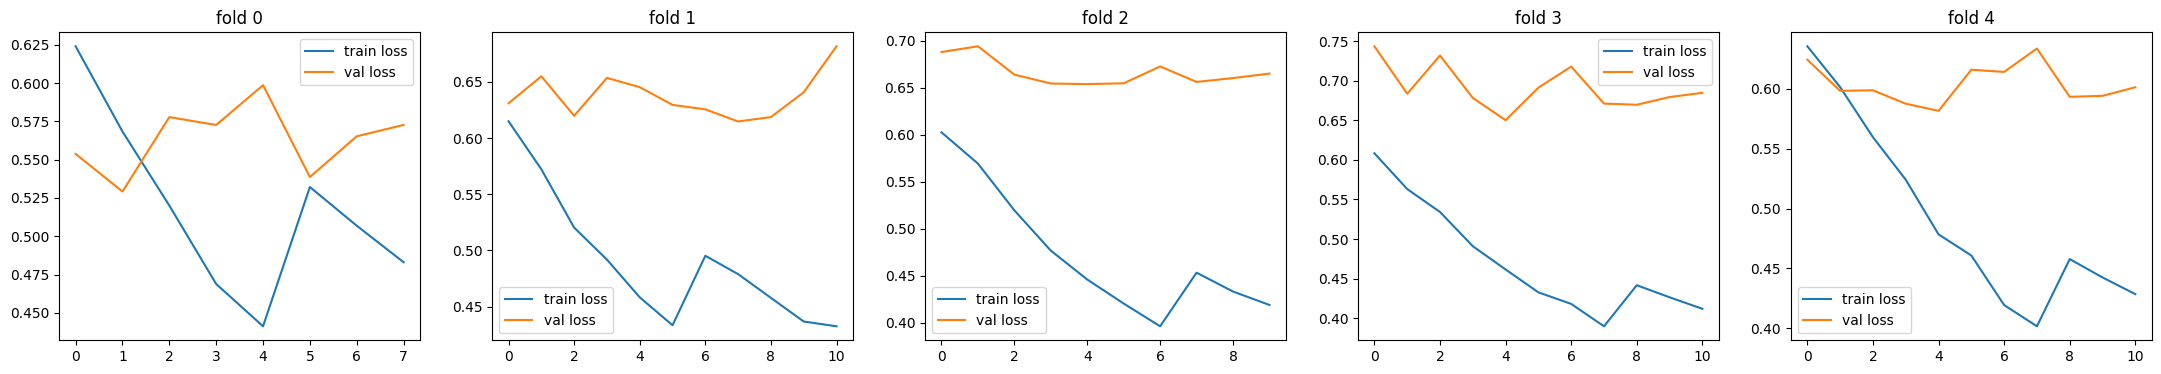

[0.5271908528318788, 0.532529673555315, 0.5343885933629526, 0.5457939970760487, 0.5338257184411034, 0.5477981657468841, 0.5311610516738726, 0.5235073568406905]
0.5477981657468841
[0.48249486767528055, 0.4769018209739863, 0.4731977930431543, 0.49691917475422653, 0.49386941809622253, 0.4964679793288047, 0.4870370465731296, 0.4935549130136764, 0.49756540710149005, 0.5079740133863849, 0.4988521787490862]
0.5079740133863849
[0.39932409321944273, 0.40230105811501204, 0.48162502871805246, 0.5155073931236728, 0.5229099711657855, 0.5331669299692561, 0.5403258885817029, 0.5286746199536903, 0.5353979676654098, 0.5337121534795958]
0.5403258885817029
[0.33921712855046215, 0.41802499969166684, 0.38785368952035676, 0.4408925518925525, 0.5031434368101038, 0.46501351734685104, 0.4589975703309041, 0.49589586956253634, 0.48898870265536964, 0.4788581418581419, 0.47399636166302855]
0.5031434368101038
[0.4700017112517116, 0.4973915436415441, 0.5233129370629374, 0.5425522625522629, 0.560389147889148, 0.51919

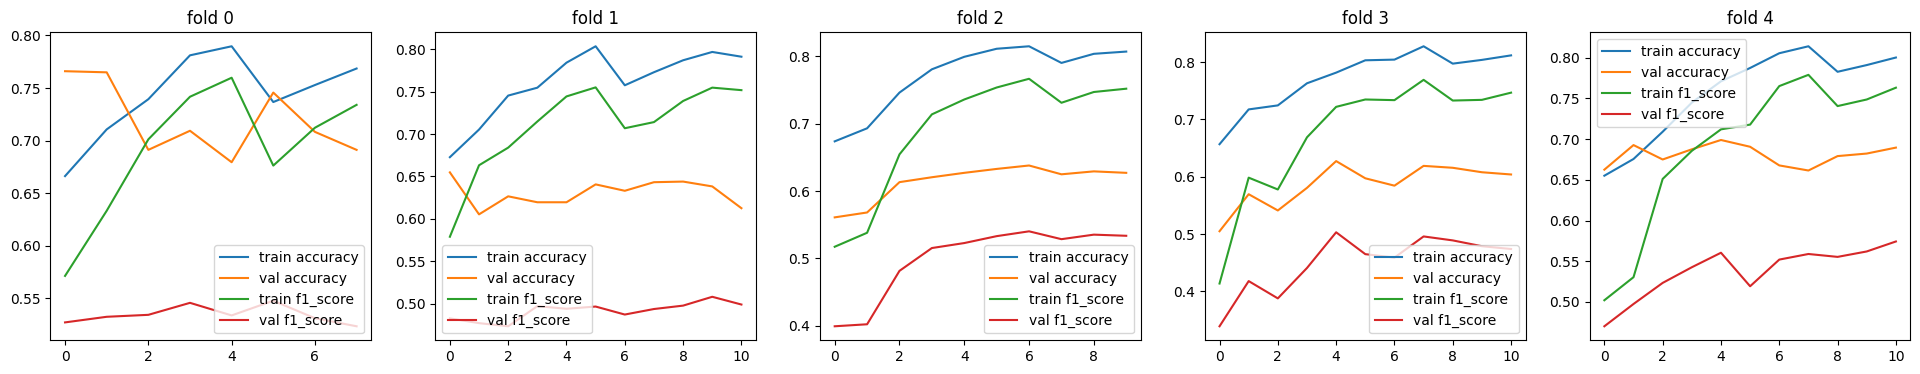

In [45]:
_, axs = plt.subplots(ncols = len(legal_bert_models_model_1), figsize=(27, 4)) 
for fold, train_data in enumerate(legal_bert_models_model_1):
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = []
    for l in temp_list:
        train_metric += l
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = []
    for l in temp_list:
        val_metric += l
    x = [i for i in range(len(val_metric))]
    axs[fold].plot(x, train_metric, label="train loss")
    axs[fold].plot(x, val_metric, label="val loss")
    axs[fold].set_title(f"fold {fold}")
    axs[fold].legend()
print("Legal bert models m1:")
plt.show()
_, axs = plt.subplots(ncols = len(legal_bert_models_model_1), figsize=(24, 4)) 
for fold, train_data in enumerate(legal_bert_models_model_1):
    for metric in ["accuracy", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = []
        for l in temp_list:
            train_metric += l
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = []
        for l in temp_list:
            val_metric += l
        if metric == 'f1_score':
            print(val_metric)
            print('best val f1 on fold', fold, ':',max(val_metric))
        x = [i for i in range(len(val_metric))]
        axs[fold].plot(x, train_metric, label=f"train {metric}")
        axs[fold].plot(x, val_metric, label=f"val {metric}")
        axs[fold].set_title(f"fold {fold}")
        axs[fold].legend()
plt.show()

In [34]:
legal_bert_models_model_2 = [] 
for fold in range(5):
    f = open(f"trainings/6.2/legal_bert_m2_fold_{fold}.json") 
    data = json.load(f)
    model = Model2(2, LEGAL_BERT) 
    model.load_state_dict(torch.load(f"weights/6.2/best_model_legal_bert_m2_fold_{fold}")) 
    losses = [train["loss"] for train in data["val"]]
    loss = []
    for l in losses:
        loss += l
    loss = min(loss)
    legal_bert_models_model_2.append({"loss": loss, "data":data, "model": model})


Legal bert models m2:


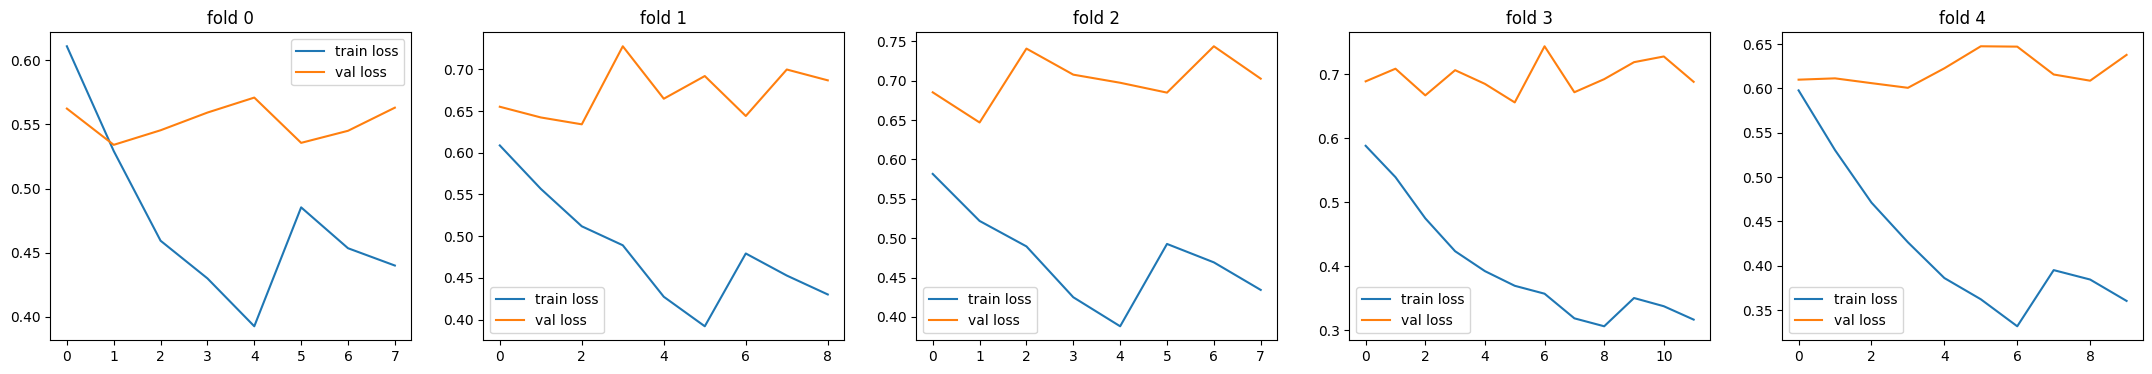

[0.5305795344256887, 0.5535519561160591, 0.5520580559042102, 0.5490888029349572, 0.5365802763238665, 0.5582921826511577, 0.5539304475201916, 0.5359148448892043]
0.5582921826511577
[0.4617106118394783, 0.4694044214662777, 0.47793721170009895, 0.45713009785174785, 0.49717464665918315, 0.496975904965596, 0.4883662299899418, 0.49588006495223014, 0.4996859097374566]
0.4996859097374566
[0.3864607937282363, 0.49584478828664913, 0.40345484618740496, 0.464392745497397, 0.48330113039415395, 0.4488243991150973, 0.4217493101214037, 0.46950562357539144]
0.49584478828664913
[0.3755783969117306, 0.38407580074246783, 0.4475666432333102, 0.4497887914554587, 0.4747571194237864, 0.4968188108188113, 0.4560164280164284, 0.5122994536327872, 0.5052156485489824, 0.48356293089626473, 0.47531902665236037, 0.5112385885719224]
0.5122994536327872
[0.508833758833759, 0.4868198930698934, 0.5141776279276283, 0.5397027047027049, 0.5378307803307806, 0.5265046065046068, 0.539540135790136, 0.5425620213120215, 0.550156695

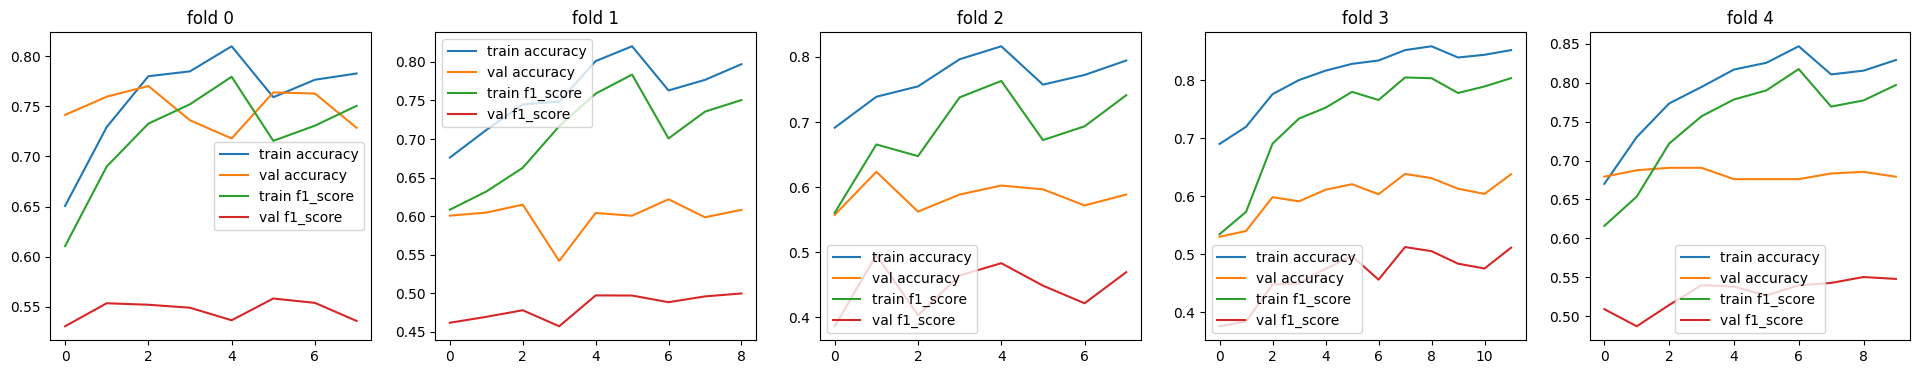

In [44]:
_, axs = plt.subplots(ncols = len(legal_bert_models_model_2), figsize=(27, 4)) 
for fold, train_data in enumerate(legal_bert_models_model_2): 
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = []
    for l in temp_list:
        train_metric += l
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = []
    for l in temp_list:
        val_metric += l
    x = [i for i in range(len(val_metric))]
    axs[fold].plot(x, train_metric, label="train loss")
    axs[fold].plot(x, val_metric, label="val loss")
    axs[fold].set_title(f"fold {fold}")
    axs[fold].legend()
print("Legal bert models m2:") 
plt.show()
_, axs = plt.subplots(ncols = len(legal_bert_models_model_2), figsize=(24, 4)) 
for fold, train_data in enumerate(legal_bert_models_model_2):
    for metric in ["accuracy", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = []
        for l in temp_list:
            train_metric += l
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = []
        for l in temp_list:
            val_metric += l
        if metric == 'f1_score':
            print(val_metric)
            print('best val f1 on fold', fold, ':',max(val_metric))
        x = [i for i in range(len(val_metric))]
        axs[fold].plot(x, train_metric, label=f"train {metric}")
        axs[fold].plot(x, val_metric, label=f"val {metric}")
        axs[fold].set_title(f"fold {fold}")
        axs[fold].legend()
plt.show()

In [37]:
roberta_models_model_1 = [] 
for fold in range(5):
    f = open(f"trainings/6.2/roberta_m1_fold_{fold}.json") 
    data = json.load(f)
    model = Model1(2, ROBERTA) 
    model.load_state_dict(torch.load(f"weights/6.2/best_model_roberta_m1_fold_{fold}"))
    losses = [train["loss"] for train in data["val"]]
    loss = []
    for l in losses:
        loss += l
    loss = min(loss)
    roberta_models_model_1.append({"loss": loss, "data":data, "model": model})


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/robe

Roberta models m1:


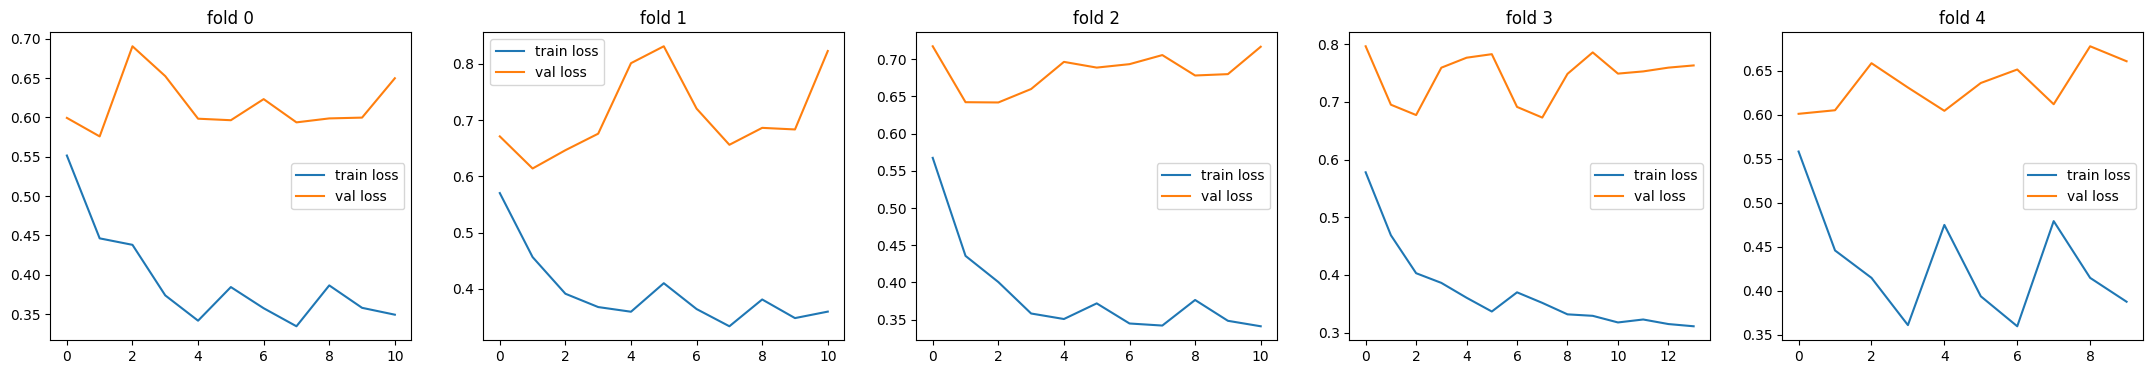

[0.5424620963082506, 0.5486950371565759, 0.5396373806630218, 0.5353541994567639, 0.5515825105568698, 0.5450754373831301, 0.5381060060547241, 0.5486747820081158, 0.5542525375858712, 0.5416429724122034, 0.5532116980834932]
0.5542525375858712
[0.4511244196811208, 0.4978846182454435, 0.512601430642668, 0.5119765400693241, 0.47766674905850187, 0.46631095136249784, 0.5095403451073555, 0.5161435929477171, 0.5097682100259422, 0.5044878374775282, 0.4873837216620723]
0.5161435929477171
[0.41017616104825444, 0.5553413640622947, 0.5440721423279569, 0.5409447464680027, 0.5469634370797167, 0.5365917674057216, 0.5291305593631178, 0.49908105460431096, 0.5487770627305516, 0.5456204002715636, 0.5079419611396361]
0.5553413640622947
[0.35700763434096805, 0.46061067327734023, 0.5037918747918749, 0.4407386070719405, 0.4476139786139789, 0.5067194533861207, 0.520443359110026, 0.5146719453386125, 0.4818186874853543, 0.47388862988863006, 0.505235233901901, 0.4906698980032314, 0.4904117117450453, 0.5087778887778

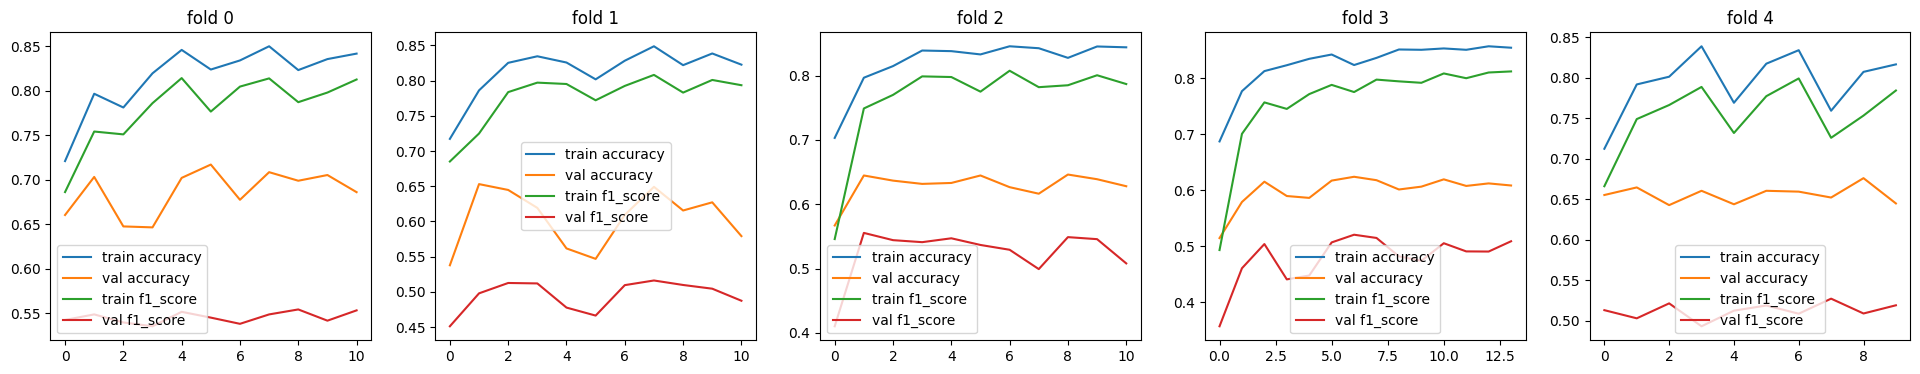

In [43]:
_, axs = plt.subplots(ncols = len(roberta_models_model_1), figsize=(27, 4))
for fold, train_data in enumerate(roberta_models_model_1):
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = []
    for l in temp_list:
        train_metric += l
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = []
    for l in temp_list:
        val_metric += l
    x = [i for i in range(len(val_metric))]
    axs[fold].plot(x, train_metric, label="train loss")
    axs[fold].plot(x, val_metric, label="val loss")
    axs[fold].set_title(f"fold {fold}")
    axs[fold].legend()
print("Roberta models m1:") 
plt.show()
_, axs = plt.subplots(ncols = len(roberta_models_model_1), figsize=(24, 4)) 
for fold, train_data in enumerate(roberta_models_model_1): 
    for metric in ["accuracy", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = []
        for l in temp_list:
            train_metric += l
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = []
        for l in temp_list:
            val_metric += l
        if metric == 'f1_score':
            print(val_metric)
            print('best val f1 on fold', fold, ':',max(val_metric))
        x = [i for i in range(len(val_metric))]
        axs[fold].plot(x, train_metric, label=f"train {metric}")
        axs[fold].plot(x, val_metric, label=f"val {metric}")
        axs[fold].set_title(f"fold {fold}")
        axs[fold].legend()
plt.show()

In [39]:
roberta_models_model_2 = []
for fold in range(5):
    f = open(f"trainings/6.2/roberta_m2_fold_{fold}.json") 
    data = json.load(f)
    model = Model2(2, ROBERTA) 
    model.load_state_dict(torch.load(f"weights/6.2/best_model_roberta_m2_fold_{fold}"))
    losses = [train["loss"] for train in data["val"]]
    loss = []
    for l in losses:
        loss += l
    loss = min(loss)
    roberta_models_model_2.append({"loss": loss, "data":data, "model": model})


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FileNotFoundError: [Errno 2] No such file or directory: 'weights/6.2/best_model_roberta_m2_fold_0'

In [40]:
_, axs = plt.subplots(ncols = len(roberta_models_model_2), figsize=(27, 4)) 
for fold, train_data in enumerate(roberta_models_model_2): 
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = []
    for l in temp_list:
        train_metric += l
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = []
    for l in temp_list:
        val_metric += l
    x = [i for i in range(len(val_metric))]
    axs[fold].plot(x, train_metric, label="train loss")
    axs[fold].plot(x, val_metric, label="val loss")
    axs[fold].set_title(f"fold {fold}")
    axs[fold].legend()
print("Roberta models m2:") 
plt.show()
_, axs = plt.subplots(ncols = len(roberta_models_model_2), figsize=(24, 4)) 
for fold, train_data in enumerate(roberta_models_model_2):
    for metric in ["accuracy", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = []
        for l in temp_list:
            train_metric += l
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = []
        for l in temp_list:
            val_metric += l
        if metric == 'f1_score':
            print(val_metric)
            print('best val f1 on fold', fold, ':',max(val_metric))
        x = [i for i in range(len(val_metric))]
        axs[fold].plot(x, train_metric, label=f"train {metric}")
        axs[fold].plot(x, val_metric, label=f"val {metric}")
        axs[fold].set_title(f"fold {fold}")
        axs[fold].legend()
plt.show()

ValueError: Number of columns must be a positive integer, not 0

<Figure size 2700x400 with 0 Axes>

In [21]:
def ARM_full_test(model, cases):
    y_true = []
    y_pred = []
    args_set = set()
    with torch.no_grad():
        for case in cases:
            for argument in case["arguments"]:
                if (argument["conclusion"] not in args_set) and (clauses[argument["conclusion"]] in law_section):
                    tokenized_x = tokenizer(clauses[argument["conclusion"]],padding = True, truncation=True, return_tensors='pt')
                    tokenized_x = {key: tokenized_x[key].to(device) for key in tokenized_x.keys()}
                    pred = model(tokenized_x)
                    y_pred.append(1 - torch.max(pred, -1)[1].view(-1).cpu().tolist()[0])
                    #y_pred.append(1)
                    y_true.append(0)
                    keys = list(tokenized_x.keys())
                    for k in keys:
                        del tokenized_x[k]
                    del tokenized_x
                    args_set.add(argument["conclusion"])
                elif argument["conclusion"] not in args_set and clauses[argument["conclusion"]] not in law_section:
                    args_set.add(argument["conclusion"])
                    y_pred.append(1)
                    y_true.append(0)
                for premise in argument["premises"]:
                    if premise not in args_set and clauses[premise] in law_section:
                        tokenized_x = tokenizer(clauses[premise], padding = True, truncation=True, return_tensors='pt')
                        tokenized_x = {key: tokenized_x[key].to(device) for key in tokenized_x.keys()}
                        pred = model(tokenized_x)
                        y_pred.append(torch.max(pred, -1)[1].view(-1).cpu().tolist()[0])
                        #y_pred.append(1)
                        y_true.append(0)
                        keys = list(tokenized_x.keys())
                        for k in keys:
                            del tokenized_x[k]
                        del tokenized_x
                        args_set.add(premise)
                        
                    elif premise not in args_set and clauses[premise] not in law_section:
                        args_set.add(premise)
                        y_pred.append(1)
                        y_true.append(0)
            for clause_id in clauses.keys():
                if (not clause_id in args_set) and (clauses[clause_id] in law_section):
                    tokenized_x = tokenizer(clauses[clause_id], padding = True, truncation=True, return_tensors='pt')
                    tokenized_x = {key: tokenized_x[key].to(device) for key in tokenized_x.keys()}
                    pred = model(tokenized_x)
                    y_pred.append(torch.max(pred, -1)[1].view(-1).cpu().tolist()[0])
                    #y_pred.append(0)
                    y_true.append(1)
                    keys = list(tokenized_x.keys())
                    for k in keys:
                        del tokenized_x[k]
                    del tokenized_x
                    args_set.add(clause_id)
                    
                if (not clause_id in args_set) and (clauses[clause_id] not in law_section):
                    y_pred.append(1)
                    y_true.append(1)
    print(y_true)
    print(y_pred)
    print(len(y_true))
    print(f"""accuracy: {accuracy_score(y_true, y_pred):.2f}
    f1: {f1_score(y_true, y_pred):.2f}
    precision: {precision_score(y_true, y_pred):.2f}
    recall: {recall_score(y_true, y_pred):.2f}""")
ARM_full_test(best_model, test_cases)

NameError: name 'full_test' is not defined

# Task 3: Premise/Conclusion Recognition

Dataloader:

In [16]:
#train_cases, validation_cases, test_cases = cases[-1]
def get_pcr_dataloader(cases, tokenizer, batch_size=16, shuffle=False, verbose=True):
    PCR_x = []
    PCR_y = []
    argdict = {}
    for case in cases:
        n_clauses = case["n_clauses"]
        clauses = case["all_clauses"]
        for argument in case["arguments"]:
            if not clauses[argument["conclusion"]] in argdict:
                argdict[clauses[argument["conclusion"]]] = [0.,1.]
            else:
                argdict[clauses[argument["conclusion"]]][1] = 1.

            for premise in argument["premises"]:
                if not clauses[premise] in argdict:
                    argdict[clauses[premise]] = [1.,0.]
                else:
                    argdict[clauses[premise]][0] = 1.

    items = list(argdict.items())
    print(len(items))
    for item in items:
        PCR_x.append(item[0])
        PCR_y.append(torch.tensor(item[1]))


    PCR_x_tokenized = dict_lists_to_list_of_dicts(tokenizer(PCR_x, padding=True, truncation=True, return_tensors='pt'))
    if verbose:
        print(f"""
    There are:
        - {len(PCR_x)} clauses
        - {len([a for a in PCR_y if a[0] == 1.])} premises
        - {len([a for a in PCR_y if a[1] == 1.])} conclusions
        """)
    
    dataset = Dataset(PCR_x_tokenized, PCR_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

print("train set:")
PCR_train_dataloader = get_pcr_dataloader(train_cases, tokenizer, shuffle=True, batch_size=8)
print("validation set:")
PCR_validation_dataloader = get_pcr_dataloader(validation_cases, tokenizer, batch_size=8)
print("test set:")
PCR_test_dataloader = get_pcr_dataloader(test_cases, tokenizer, batch_size=8)

train set:
1607

    There are:
        - 1607 clauses
        - 1279 premises
        - 451 conclusions
        
validation set:
199

    There are:
        - 199 clauses
        - 157 premises
        - 62 conclusions
        
test set:
561

    There are:
        - 561 clauses
        - 441 premises
        - 155 conclusions
        


In [17]:
class ModelPCR(NeuralNetwork):
    def __init__(self, out_features:int, bert_type:str, dropout:float = 0.2) -> None:
        super().__init__()
        if bert_type == ROBERTA:
            self.encoder = RobertaModel.from_pretrained(bert_type)
        else:     
            self.encoder = AutoModel.from_pretrained(bert_type)
        self.output_layer = nn.Linear(self.encoder.config.hidden_size, out_features)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        encoded_input, _ = self.encoder(**input, return_dict = False)
        encoded_input = self.dropout(encoded_input)
        encoded_input = torch.nn.functional.avg_pool1d(
            encoded_input.permute(0, 2, 1), 
            kernel_size=encoded_input.size(1)
        ).squeeze(2)
        return self.output_layer(encoded_input).float()

    def freeze_bert(self):
        for param in self.encoder.parameters():
                param.requires_grad = False
    def unfreeze_bert(self):
        for param in self.encoder.parameters():
                param.requires_grad = True

In [18]:
legal_bert_models = fold_training(cases, LEGAL_BERT, 5e-7, 1e-6, .6, get_pcr_dataloader, ModelPCR, loss=nn.BCEWithLogitsLoss())

1592
214
EPOCH 1 training loss:      0.513 - validation loss:      0.619                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.802 - validation accuracy:      0.747
EPOCH 1 training f1_score:      0.515 - validation f1_score:      0.462
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.421 - validation loss:      0.552                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.838 - validation accuracy:      0.742
EPOCH 2 training f1_score:      0.667 - validation f1

In [19]:
for i, model_data in enumerate(legal_bert_models):
    f = open(f"trainings/6.3/legal_bert_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(legal_bert_models):
    torch.save(model_info["model"].state_dict(), f"weights/6.3/best_model_legal_bert_fold_{i}")
    model_info["model"] = model_info["model"].to("cpu")

In [18]:
roberta_models = fold_training(cases, ROBERTA, 2e-7, 6e-6, .6, get_pcr_dataloader, ModelPCR)
for i, model_data in enumerate(roberta_models):
    f = open(f"trainings/6.3/roberta_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(roberta_models):
    torch.save(model_info["model"].state_dict(), f"weights/6.3/best_model_roberta_fold_{i}")
    model_info["model"] = model_info["model"].to("cpu")

1592
214


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning rate = 6e-06
EPOCH 1 training loss:      0.450 - validation loss:      0.596                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.860 - validation accuracy:      0.770
EPOCH 1 training f1_score:      0.705 - validation f1_score:      0.627
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.327 - validation loss:      0.575                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.883 - validation accuracy:      0.789
EPOCH 2 training f1_score:      0.789 - 

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning rate = 6e-06
EPOCH 1 training loss:      0.468 - validation loss:      0.550                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.848 - validation accuracy:      0.790
EPOCH 1 training f1_score:      0.704 - validation f1_score:      0.585
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.359 - validation loss:      0.599                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.884 - validation accuracy:      0.819
EPOCH 2 training f1_score:      0.767 - 

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning rate = 6e-06
EPOCH 1 training loss:      0.501 - validation loss:      0.491                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.846 - validation accuracy:      0.841
EPOCH 1 training f1_score:      0.711 - validation f1_score:      0.629
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.394 - validation loss:      0.407                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.855 - validation accuracy:      0.863
EPOCH 2 training f1_score:      0.774 - 

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning rate = 6e-06
EPOCH 1 training loss:      0.492 - validation loss:      0.452                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.829 - validation accuracy:      0.853
EPOCH 1 training f1_score:      0.692 - validation f1_score:      0.637
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.388 - validation loss:      0.384                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.871 - validation accuracy:      0.877
EPOCH 2 training f1_score:      0.776 - 

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning rate = 6e-06
EPOCH 1 training loss:      0.479 - validation loss:      0.530                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.824 - validation accuracy:      0.845
EPOCH 1 training f1_score:      0.705 - validation f1_score:      0.778
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.357 - validation loss:      0.450                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.876 - validation accuracy:      0.870
EPOCH 2 training f1_score:      0.776 - 

Roberta models:


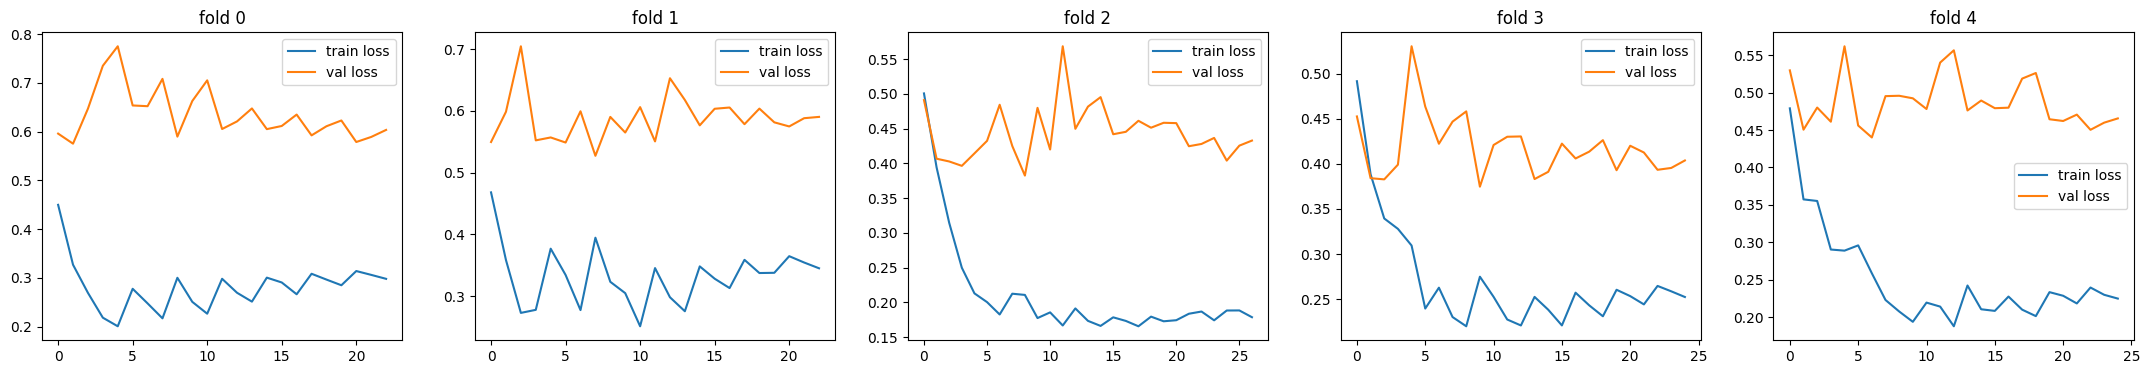

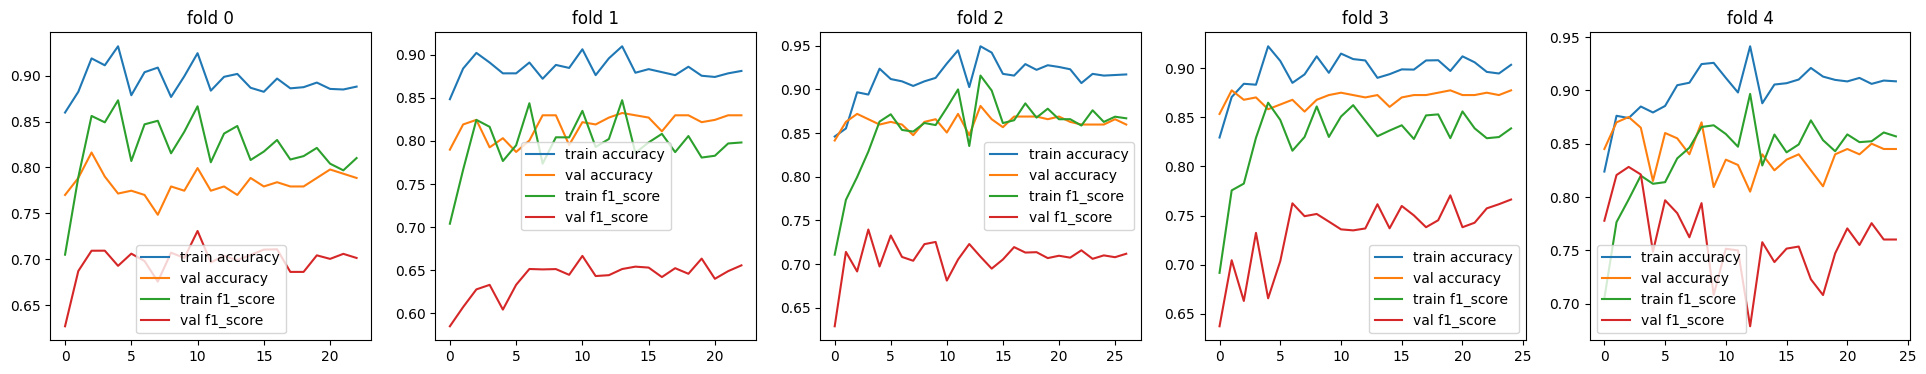

In [19]:
_, axs = plt.subplots(ncols = len(roberta_models), figsize=(27, 4)) 
for fold, train_data in enumerate(roberta_models):
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = []
    for l in temp_list:
        train_metric += l
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = []
    for l in temp_list:
        val_metric += l
    x = [i for i in range(len(val_metric))]
    axs[fold].plot(x, train_metric, label="train loss")
    axs[fold].plot(x, val_metric, label="val loss")
    axs[fold].set_title(f"fold {fold}")
    axs[fold].legend()
print("Roberta models:")
plt.show()
_, axs = plt.subplots(ncols = len(roberta_models), figsize=(24, 4)) 
for fold, train_data in enumerate(roberta_models):
    for metric in ["accuracy", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = []
        for l in temp_list:
            train_metric += l
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = []
        for l in temp_list:
            val_metric += l
        x = [i for i in range(len(val_metric))]
        axs[fold].plot(x, train_metric, label=f"train {metric}")
        axs[fold].plot(x, val_metric, label=f"val {metric}")
        axs[fold].set_title(f"fold {fold}")
        axs[fold].legend()
plt.show()

# Evaluation

## Evaluation of models for task 1:

## Evaluation of models for task 2:

### Legal bert m1

In [18]:
model = Model1(2, LEGAL_BERT).to(device)
model.load_state_dict(torch.load(f"weights/6.2/best_model_legal_bert_m1_fold_{4}")) #fold 4 is the best (validation set) fold for bert m1

<All keys matched successfully>

In [50]:
def test(model, dataset, device):
    def to(data, device):
        if isinstance(data, torch.Tensor):
            return data.to(device)
        if isinstance(data, dict):
            return {k: to(v, device) for k, v in data.items()}
    model = model.to(device)
    model.eval()
    predictions, true_labels, errors, error_types, wrong_examples = [], [], [], [], []
    batch_size = dataset.batch_size
    for idx, (inputs, labels) in enumerate(dataset):
        inputs = to(inputs, device)
        with torch.no_grad():
                outputs = model(inputs)
        preds = outputs.argmax(dim=-1).cpu().tolist()
        labels = labels.argmax(dim=-1).tolist()
        for i in range(len(preds)):
            if preds[i] != labels[i]:
                errors.append((idx * batch_size) + i) 
                if labels[i] == 0:
                     error_types.append('FN') #label 0 means that original tensor is [1,0], so both sentences are in the same argument
                else:
                     error_types.append('FP')
                wrong_examples.append((inputs['e1']['input_ids'][i].tolist(),inputs['e2']['input_ids'][i].tolist()))
        predictions += preds
        true_labels += labels
        del inputs 
        del outputs
    return (predictions, true_labels), errors, error_types, wrong_examples

In [51]:
(predictions, true_labels), new_e, error_types, wrong_examples = test(model, ARM_test_dataloader, device)
print('f1 score:', f1_score(predictions, true_labels))
print('accuracy score:', accuracy_score(predictions, true_labels))

0.7209424083769633

In [ ]:
print('predicted positives:',predictions.count(0),'     predicted negatives:', predictions.count(1)) 
print('positive labels:',true_labels.count(0), '     negative labels:', true_labels.count(1))
print('false positives:', error_types.count('FP'), '     false negatives:', error_types.count('FN'), '     total errors:', len(error_types))
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
for i in range(len(wrong_examples)):
    print('wrong classification number', i + 1,':')
    print(tokenizer.decode(wrong_examples[i][0]))
    print(tokenizer.decode(wrong_examples[i][1]))
    print('Type of error:', error_types[i])
    print()
    print()


### Legal bert m2

In [ ]:
model = Model2(2, LEGAL_BERT).to(device)
model.load_state_dict(torch.load(f"weights/6.2/best_model_legal_bert_m2_fold_{0}")) #fold 0 is the best (validation set) fold for bert m2

In [ ]:
(predictions, true_labels), new_e, error_types, wrong_examples = test(model, ARM_test_dataloader, device)
print('f1 score:', f1_score(predictions, true_labels))
print('accuracy score:', accuracy_score(predictions, true_labels))
print(len(predictions), len(true_labels))


In [ ]:
print('predicted positives:',predictions.count(0),'     predicted negatives:', predictions.count(1)) #conto prima positivi, poi negativi
print('positive labels:',true_labels.count(0), '     negative labels:', true_labels.count(1))
print('false positives:', error_types.count('FP'), '     false negatives:', error_types.count('FN'), '     total errors:', len(error_types))
print()
print()
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
for i in range(len(wrong_examples)):
    print('wrong classification number', i + 1,':')
    print(tokenizer.decode(wrong_examples[i][0]))
    print(tokenizer.decode(wrong_examples[i][1]))
    print('Type of error:', error_types[i])
    print()
    print()

Note: in both cases the false negative rate is much greater than the false positive rate. ---> maybe this is due to the fact that recognizing positive might be difficult when very different premises support the same conclusion

### Roberta m1

!!! IMPORTANTE: rerunna la def di ARM dataloader col tokenizer giusto (qui sotto) 

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")

model = Model1(2, ROBERTA).to(device)
model.load_state_dict(torch.load(f"weights/6.2/best_model_roberta_m1_fold_{2}")) #fold 2 is the best (validation set) fold for roberta m1

In [ ]:
(predictions, true_labels), new_e, error_types, wrong_examples = test(model, ARM_test_dataloader, device)
print('f1 score:', f1_score(predictions, true_labels))
print('accuracy score:', accuracy_score(predictions, true_labels))
print(len(predictions), len(true_labels))


In [ ]:
print('predicted positives:',predictions.count(0),'     predicted negatives:', predictions.count(1)) #conto prima positivi, poi negativi
print('positive labels:',true_labels.count(0), '     negative labels:', true_labels.count(1))
print('false positives:', error_types.count('FP'), '     false negatives:', error_types.count('FN'), '     total errors:', len(error_types))
print()
print()

for i in range(len(wrong_examples)):
    print('wrong classification number', i + 1,':')
    print(tokenizer.decode(wrong_examples[i][0]))
    print(tokenizer.decode(wrong_examples[i][1]))
    print('Type of error:', error_types[i])
    print()
    print()

In questo caso false positive e negati rates sono simili

### Roberta m2

In [ ]:
model = Model2(2, ROBERTA).to(device)
#model.load_state_dict(torch.load(...)) #non ho i pesi, non so quale sia la fold migliore

In [ ]:
(predictions, true_labels), new_e, error_types, wrong_examples = test(model, ARM_test_dataloader, device)
print('f1 score:', f1_score(predictions, true_labels))
print('accuracy score:', accuracy_score(predictions, true_labels))
print(len(predictions), len(true_labels))

In [ ]:
print('predicted positives:',predictions.count(0),'     predicted negatives:', predictions.count(1)) #conto prima positivi, poi negativi
print('positive labels:',true_labels.count(0), '     negative labels:', true_labels.count(1))
print('false positives:', error_types.count('FP'), '     false negatives:', error_types.count('FN'), '     total errors:', len(error_types))
print()
print()

for i in range(len(wrong_examples)):
    print('wrong classification number', i + 1,':')
    print(tokenizer.decode(wrong_examples[i][0]))
    print(tokenizer.decode(wrong_examples[i][1]))
    print('Type of error:', error_types[i])
    print()
    print()

## Evaluation of models for task 3: